In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime,timedelta
import datetime as dt

## **Issue at stake**

**' Build a profitable Tennis betting algorithm '** 

1. Build a predictive model that can output the prediction for player A or player B to win

2. Check the prediction against the most profitable bookmaker and calculate the expected profit:


> A. Build a confidence metrics for each game -> comparison between our   probabilities and the bookmaker probabilities.



> B. Set a threshold to tell on which game we want to bet.


> C. Forecast future profit (bet the same amount on all games or change bet according to confidence value)


## **To do List**


0. **PARTIE1:** Comprendre la construction du ranking ELO.

1. **PARTIE1:** Creer de nouvelles variables explicatives -> Exemple Victoires par surface + indoor vs outdoor + nombre de finales jouees cette annee.

**NB: le scaling cree un leger desequilibre du modele au profit du classement ATP/WTA (Que l'on soit en Standard ou Quantile)**

2. **PARTIE1:** Donnees complementaires a ajouter depuis par exemple https://www.ultimatetennisstatistics.com/peakEloRatings (ex: best Elo rating,stats joueurs) 

3. **PARTIE1:** Tester differents modeles de classification -> **A poursuivre -> Non optimise**   

4. **PARTIE1:** Mise en place de **Pipelines** (automatisation des taches et code 'propre')

5. **PARTIE1:** Tester **RandomizeSearchCV** pour la recherche des hyperparametres (Cf. Pierre) + utilisation du package **OPTUNA**

6. **PARTIE1:** Ajouter des metriques

7. **PARTIE2:** Utiliser la methode 'predict_proba' de la Classification par Regression Logistique pour recuperer les probabilites de classification entre les 2 classes. 
https://openclassrooms.com/fr/courses/4297211-evaluez-les-performances-dun-modele-de-machine-learning/4308261-evaluez-un-algorithme-de-classification-qui-retourne-des-scores
**courbe de ROC?**

8. **PARTIE2:** Suite au point 7. definir un seuil de proba // seuil de confiance. Ex: avec un seuil de 80%: Les victoires probabilisees a + de 80% sont considerees comme tres probables et donc ce taux peut etre rapproche de celui du bookmaker et s'il est tres superieur a celui-ci on peut avoir confiance dans le fait de parier.

9. **PARTIE2:** Developper modele economique rentable en considerant des mises variables et tester des simulations de gains sur mois/annees. Considerer par exemple uniquement les challengers avec des cotes > 2 et miser lorsque notre confiance sur ces matchs > bookmaker de 50%

10. **PARTIES 1&2:** Optimiser ecriture du code (tests redondants, etc)

11. **PARTIES 1&2:** Etude sur championnat feminin (WTA) / Comment les bookmakers construisent-ils leurs algos? / Test regression lineaire? / Mix men and women data? / Analyse des cotes des bookmakers en fonction des mois









## **Info**

- Proba elo = probability of a given player A winning according to it Elo.

if elo_player A = elo_player B, the probability is 50%

if elo_player A > elo_player B, the probability is >50%

if elo_player A < elo_player B, the probability is <50%

Ex: +100 points = 64% chance of winning / +200 points = 76%

- Une autre equipe a dupplique le dataset avec une ligne par joueur et exclut les joueurs presentant trop peu de matchs joues suite a analyse graphique.
Ils ont utilise les modeles des classification suivants: Regression,SVM,KNN,Random Forest, Decision Tree.
Ils auraient atteint une accuracy de 0.9.

- Discute avec Jeremy : on pourra tester des modeles avec et sans les cotes des bookmakers

# **CODE PROPRE**

1. With more data, be careful to use the same data (esp. after pre-processing)


## **data Exploration**

In [ ]:
url = 'https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/atp_data.csv'
data = pd.read_csv(url)
data.tail()


,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,Wsets,Lsets,Comment,PSW,PSL,B365W,B365L,elo_winner,elo_loser,proba_elo
44703,17,Dubai,Dubai Tennis Championships,2018-03-03,ATP500,Outdoor,Hard,The Final,3,Bautista Agut R.,Pouille L.,23,15,2.0,0.0,Completed,1.65,2.43,1.66,2.20,1835.901543,1842.459807,0.490563
44704,16,Acapulco,Abierto Mexicano,2018-03-03,ATP500,Outdoor,Hard,Semifinals,3,Anderson K.,Donaldson J.,8,59,2.0,1.0,Completed,1.34,3.63,1.30,3.50,1843.576914,1647.967561,0.755103
44705,18,Sao Paulo,Brasil Open,2018-03-03,ATP250,Indoor,Clay,Semifinals,3,Jarry N.,Zeballos H.,73,69,2.0,1.0,Completed,1.85,2.09,1.90,1.90,1588.293069,1619.758421,0.454841
44706,16,Acapulco,Abierto Mexicano,2018-03-04,ATP500,Outdoor,Hard,The Final,3,Del Potro J.M.,Anderson K.,9,8,2.0,0.0,Completed,1.52,2.75,1.50,2.62,1966.532849,1851.413609,0.659862
44707,18,Sao Paulo,Brasil Open,2018-03-04,ATP250,Indoor,Clay,The Final,3,Fognini F.,Jarry N.,20,73,2.0,1.0,Completed,1.38,3.38,1.36,3.25,1814.065865,1605.738153,0.768388


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44708 entries, 0 to 44707
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ATP         44708 non-null  int64  
 1   Location    44708 non-null  object 
 2   Tournament  44708 non-null  object 
 3   Date        44708 non-null  object 
 4   Series      44708 non-null  object 
 5   Court       44708 non-null  object 
 6   Surface     44708 non-null  object 
 7   Round       44708 non-null  object 
 8   Best of     44708 non-null  int64  
 9   Winner      44708 non-null  object 
 10  Loser       44708 non-null  object 
 11  WRank       44708 non-null  int64  
 12  LRank       44708 non-null  int64  
 13  Wsets       44521 non-null  float64
 14  Lsets       44521 non-null  float64
 15  Comment     44708 non-null  object 
 16  PSW         32743 non-null  float64
 17  PSL         32743 non-null  float64
 18  B365W       39037 non-null  float64
 19  B365L       39057 non-nul

In [ ]:
data.describe()

,ATP,Best of,WRank,LRank,Wsets,Lsets,PSW,PSL,B365W,B365L,elo_winner,elo_loser,proba_elo
count,44708.000000,44708.000000,44708.000000,44708.000000,44521.000000,44521.000000,32743.000000,32743.000000,39037.000000,39057.000000,44708.000000,44708.000000,44708.000000
mean,32.803659,3.372596,59.159681,93.674108,2.140630,0.406325,1.927563,4.240179,1.822246,3.551007,1684.023280,1608.755552,0.585594
std,18.170565,0.778702,74.881003,124.987643,0.462388,0.557349,1.359136,5.744329,1.107547,3.498689,179.246422,137.949299,0.198732
min,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.010000,1.000000,1.002000,1318.945207,1327.551888,0.008899
25%,19.000000,3.000000,17.000000,35.000000,2.000000,0.000000,1.270000,1.794000,1.220000,1.720000,1548.476977,1501.546103,0.447921
50%,32.000000,3.000000,41.000000,65.000000,2.000000,0.000000,1.549000,2.660000,1.500000,2.500000,1652.866073,1580.743828,0.589218
75%,49.000000,3.000000,77.000000,105.000000,2.000000,1.000000,2.140000,4.270000,2.000000,4.000000,1780.755524,1684.607134,0.737288
max,69.000000,5.000000,2000.000000,2000.000000,3.000000,2.000000,46.000000,121.000000,29.000000,101.000000,2392.408923,2392.595567,0.995601


In [ ]:
data.nunique()

ATP              69
Location        115
Tournament      207
Date           4104
Series            8
Court             2
Surface           4
Round             8
Best of           2
Winner          899
Loser          1400
WRank           587
LRank           920
Wsets             4
Lsets             3
Comment           4
PSW            1177
PSL            1580
B365W           133
B365L           137
elo_winner    44297
elo_loser     43522
proba_elo     44555
dtype: int64

In [ ]:
data.isnull().sum()

ATP               0
Location          0
Tournament        0
Date              0
Series            0
Court             0
Surface           0
Round             0
Best of           0
Winner            0
Loser             0
WRank             0
LRank             0
Wsets           187
Lsets           187
Comment           0
PSW           11965
PSL           11965
B365W          5671
B365L          5651
elo_winner        0
elo_loser         0
proba_elo         0
dtype: int64

In [ ]:
# Catgorical data transformed in numerical data for correlation analysis

data_H = data.copy() # -> No impact on data

data_H["Location"] = data_H["Location"].astype('category')
data_H["Location"] = data_H["Location"].cat.codes
data_H["Tournament"] = data_H["Tournament"].astype('category')
data_H["Tournament"] = data_H["Tournament"].cat.codes
data_H["Date"] = data_H["Date"].astype('category')
data_H["Date"] = data_H["Date"].cat.codes
data_H["Series"] = data_H["Series"].astype('category')
data_H["Series"] = data_H["Series"].cat.codes
data_H["Court"] = data_H["Court"].astype('category')
data_H["Court"] = data_H["Court"].cat.codes
data_H["Surface"] = data_H["Surface"].astype('category')
data_H["Surface"] = data_H["Surface"].cat.codes
data_H["Round"] = data_H["Round"].astype('category')
data_H["Round"] = data_H["Round"].cat.codes
data_H["Winner"] = data_H["Winner"].astype('category')
data_H["Winner"] = data_H["Winner"].cat.codes
data_H["Loser"] = data_H["Loser"].astype('category')
data_H["Loser"] = data_H["Loser"].cat.codes
data_H["Comment"] = data_H["Comment"].astype('category')
data_H["Comment"] = data_H["Comment"].cat.codes


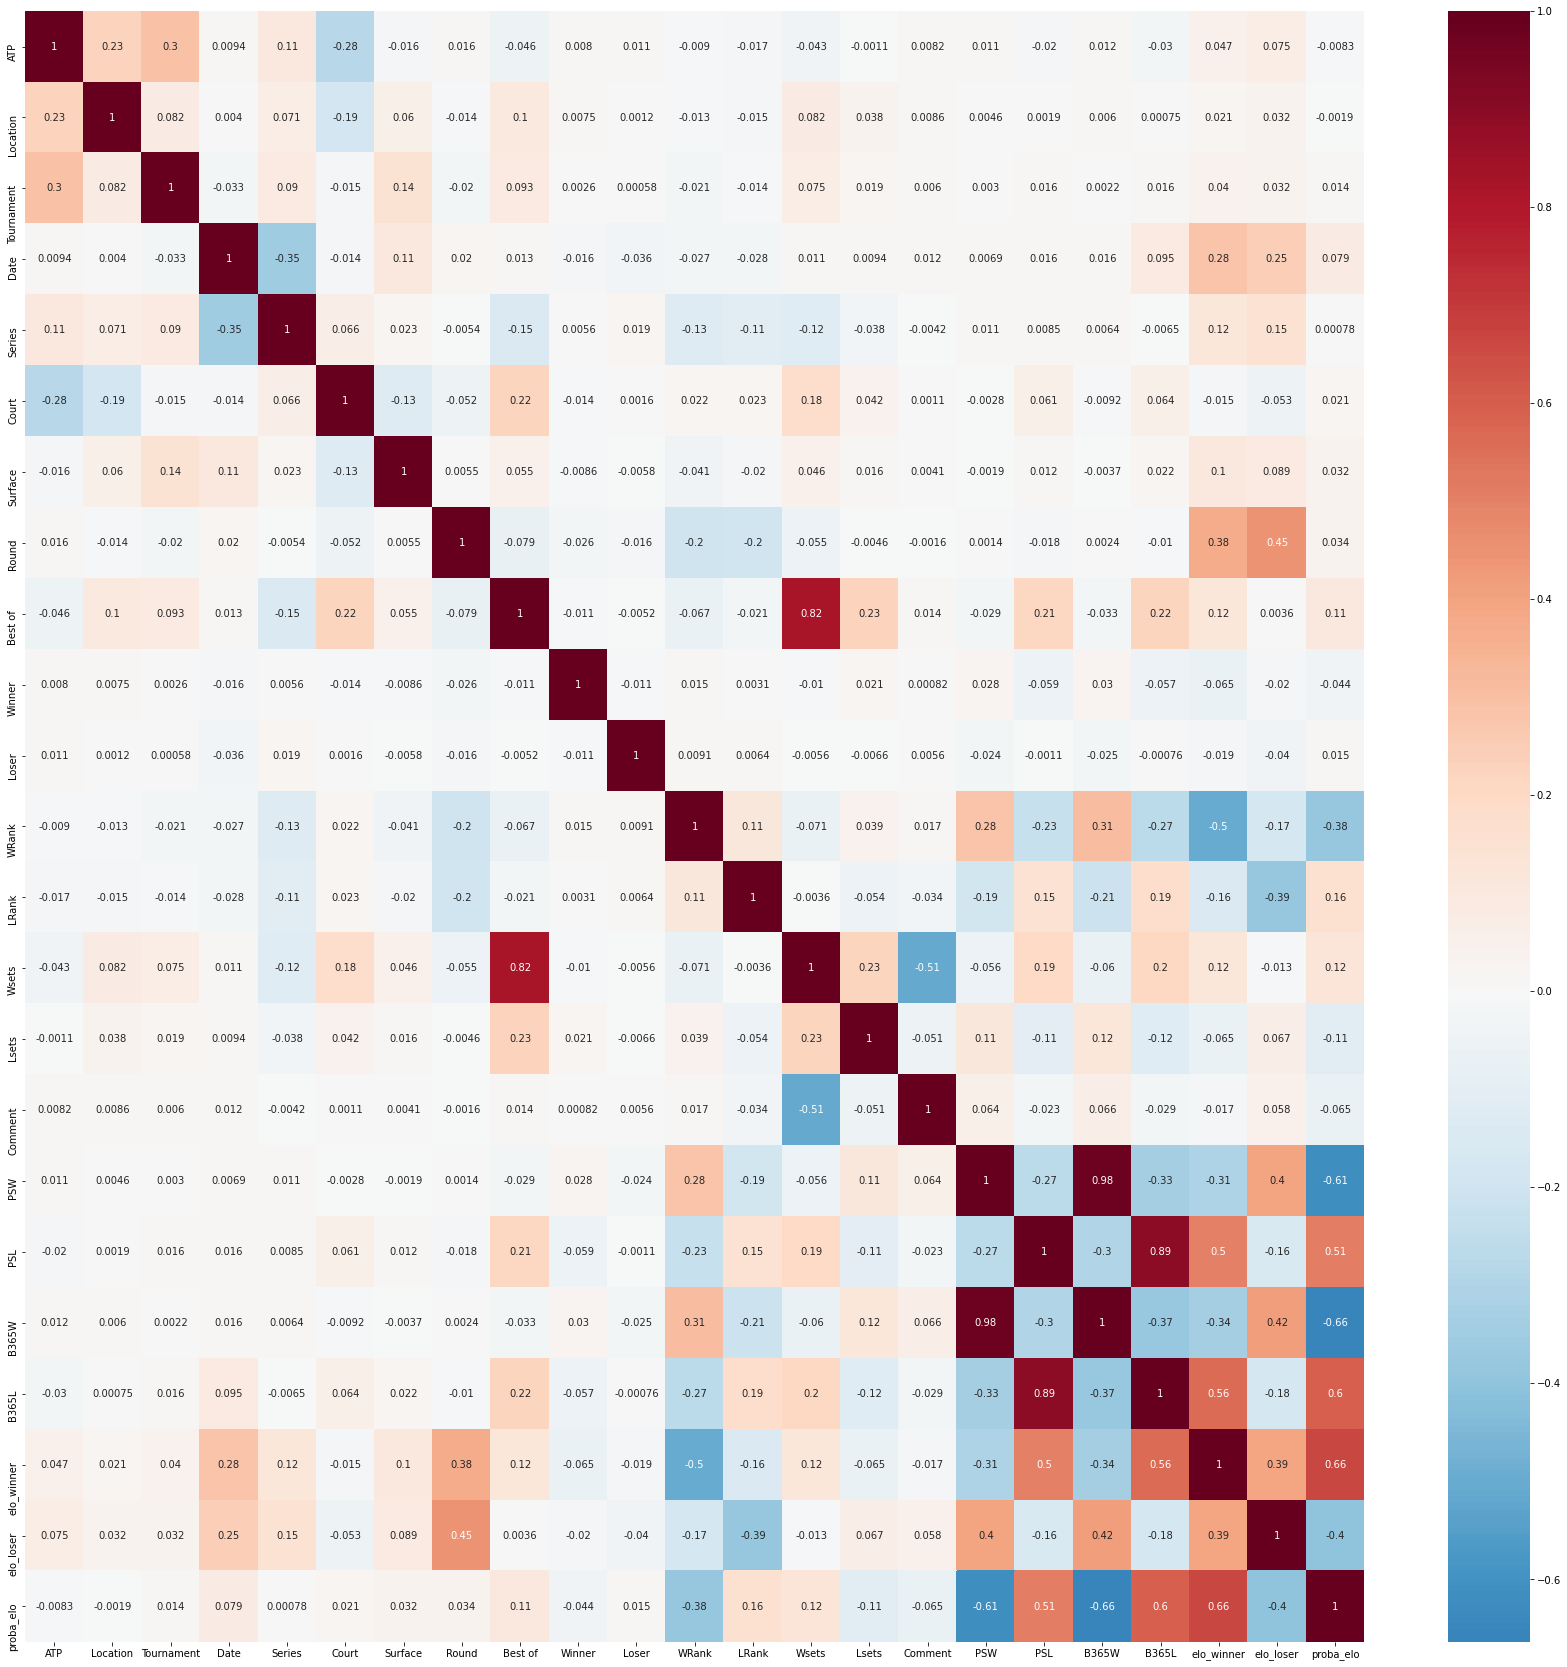

In [ ]:
# Heatmap 

plt.figure(figsize=(30,30))
correlation = data_H.corr()
sns.heatmap(correlation,  annot=True, cmap="RdBu_r", center =0);
plt.show()

## **dataviz**

### **data Distribution**

**1. data distribution visualization**

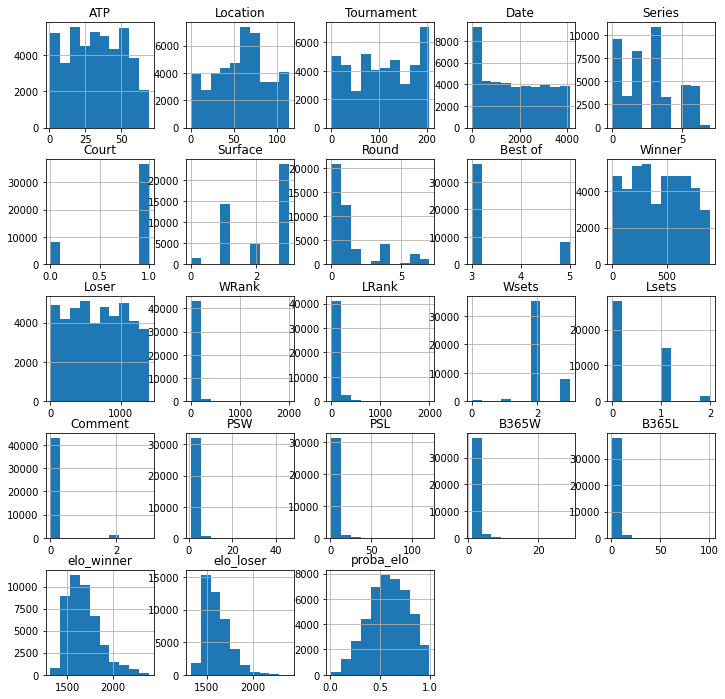

In [ ]:
#  used data_h instead of data to allow to check abnormal outliers like in 'Date'

data_H.hist(figsize=(12,12));

**2. Unique Winners and Losers in the dataset**

In [ ]:

# How many 

print('Unique Winner Players:',data.Winner.nunique())
print('Unique Loser Players:',data.Loser.nunique())


Unique Winner Players: 899
Unique Loser Players: 1400


**3. Surface distribution**

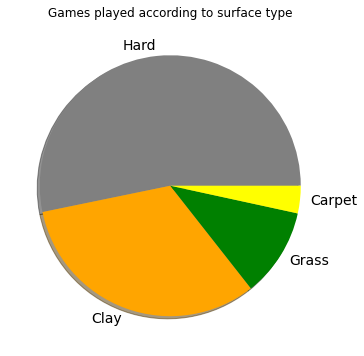

In [ ]:
# Surface distribution

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

ax.pie(x = data.Surface.value_counts(), labels = ['Hard', 'Clay', 'Grass', 'Carpet'],
           colors = ['grey', 'orange', 'green', 'yellow'],
           #autopct = lambda x: str(round(x, 1)) + '%',
           pctdistance = 0.7, labeldistance = 1.08,
           textprops={'fontsize': 14},
           shadow = True)

ax.set_title('Games played according to surface type',fontsize = 12);

**4. Series distribution**

Text(0.5, 1.0, 'Games by Series')

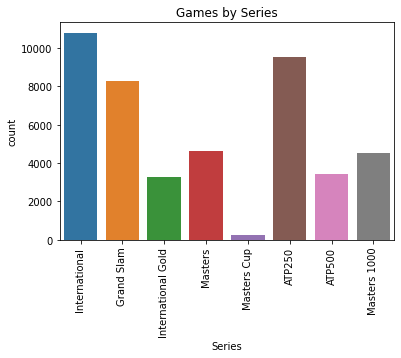

In [ ]:
# Games by Series

sns.countplot(x="Series", data=data);
plt.xticks(rotation=90)
plt.title('Games by Series')

**5. Bookmaker odds distribution**

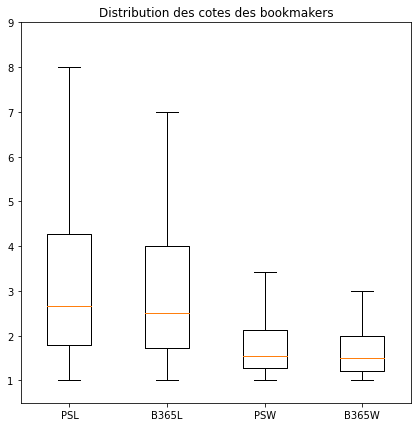

In [ ]:

data_cleared = data.copy()
data_cleared.dropna(axis=0,inplace=True)

fig = plt.figure(figsize=(7,7))

plt.boxplot([data_cleared.PSL,data_cleared.B365L,data_cleared.PSW,data_cleared.B365W],labels=['PSL','B365L','PSW','B365W'],showfliers=False)

plt.ylim(0.5,9)
plt.title('Distribution des cotes des bookmakers');

ODDS look less generous with B365   
Losers odds are around 2.7 while winner odds are around 1.7.

**6. Temporal distribution**

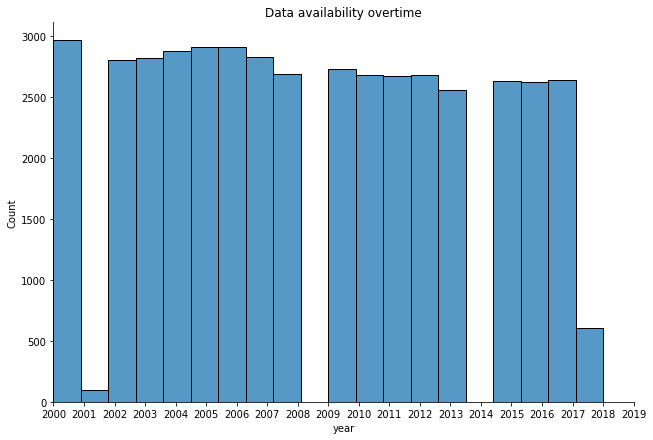

In [ ]:

data['year'] = pd.to_datetime(data.Date).dt.year
sns.displot(data.year,bins=20,height=6, aspect=1.5)

plt.xlim([2000,2019])
plt.xticks(np.arange(2000,2020, 1))

plt.title('Data availability overtime');



We can easily spot some data gaps around 2001,2008,2014. We will need to take that into account for our model construction.


**7. Ranks distribution**

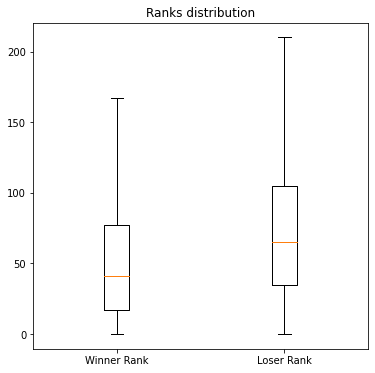

In [ ]:

fig = plt.figure(figsize=(6,6))

plt.boxplot([data.WRank,data.LRank],labels=['Winner Rank','Loser Rank'],showfliers=False)

plt.title('Ranks distribution');

Most Winner/Loser ranks are in a range between 20 t0 100. It is different than the player distribution though as some players may have played many games

### **Relationships between variables**

### Relationships between variables initially in the dataset 

**1. Series vs Years**

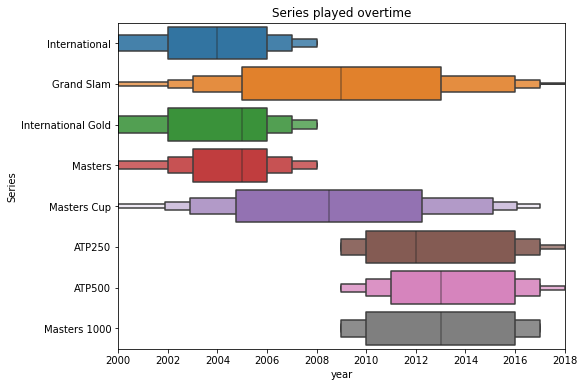

In [ ]:
data['year'] = (pd.to_datetime(data.Date)).dt.year
plt.figure(figsize=(8, 6))
sns.boxenplot(x=data.year, y=data.Series);

plt.xlim([2000,2018])

plt.title('Series played overtime');

From 2009 onwards the type of series involved are only Grand Slam, Masters Cup, ATP250, ATP500 and Masters 1000

**2. Relation between ATP & ELO ranks and players odds**

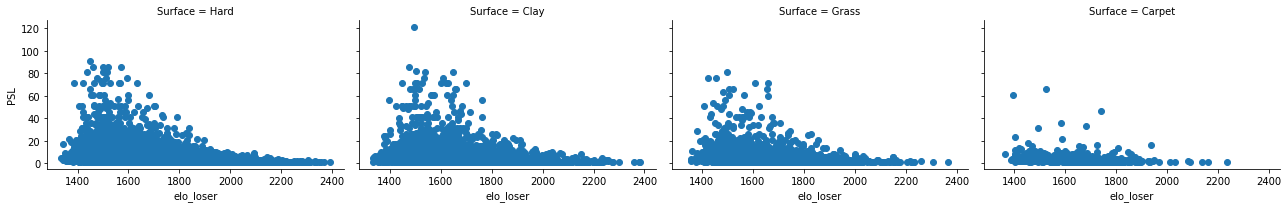

In [ ]:
#relation between Elo Rank for losers and Pinnacle odds according to the Surface

g = sns.FacetGrid(data, col="Surface",aspect=1.5)
g.map(plt.scatter, "elo_loser", "PSL");



At Pinnacle, the better the Elo_rank of the player, the smaller the odd. 

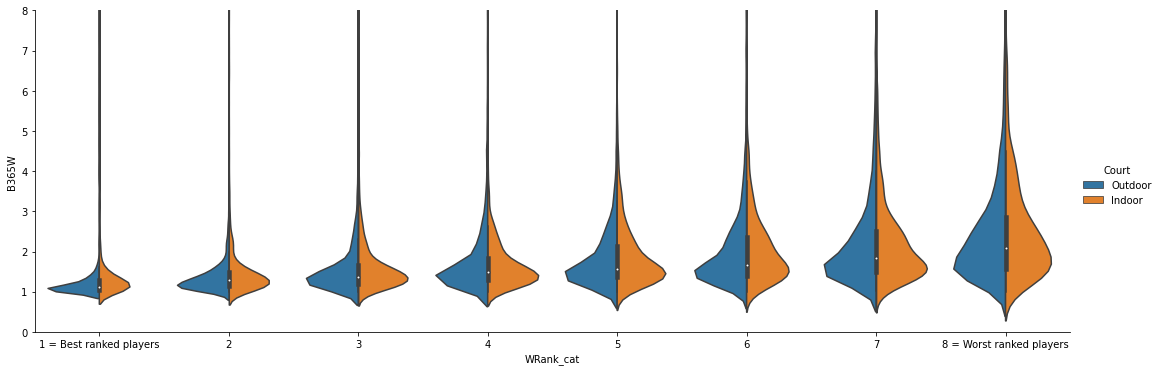

In [ ]:
#relation between ATP Rank for winners and B365 odds according to the type of tournament

data['WRank_cat']=pd.qcut(data['WRank'],labels=['1 = Best ranked players','2','3','4','5','6','7','8 = Worst ranked players'],q=8)

ax=sns.catplot(x="WRank_cat", y="B365W", hue="Court", split=True, kind="violin", data=data,showfliers=False,aspect=3)

ax.set(ylim=(0, 8));



AT B365, most odds are comprised between 1 and 4 and they tend to increase with lower ranked players

Those examples tend to confirm the negative correlation between players ranks and their odds.

### Relationships between variables created/transformed

**1. Players vs Games played, win/lose rate**

In [ ]:
# Number of Victories/Defeats/Games per player

Victories = pd.DataFrame(data.Winner.value_counts())
Defeats = pd.DataFrame(data.Loser.value_counts())
Games = pd.concat([Victories,Defeats], axis = 1)

# Players index as a column so that we can check duplicates

Games = Games.rename_axis('Players').reset_index()
print('Duplicates:',Games.duplicated().sum())

# NaN generated are replaced with 0 (for example a player has 5 defeats but no victory)

Games.fillna(0,inplace=True)

# Add the number of games played + victory rate

Games['Played']=Games['Winner']+Games['Loser']
Games['%Win']=Games['Winner']/Games['Played']

print('\n',Games.head(),'\n','\n',Games.tail())

Duplicates: 0

        Players  Winner  Loser  Played      %Win
0   Federer R.   970.0  190.0  1160.0  0.836207
1     Nadal R.   803.0  175.0   978.0  0.821063
2  Djokovic N.   687.0  146.0   833.0  0.824730
3    Ferrer D.   632.0  325.0   957.0  0.660397
4    Murray A.   560.0  165.0   725.0  0.772414 
 
             Players  Winner  Loser  Played  %Win
1397  Ratiwatana S.     0.0    1.0     1.0   0.0
1398     Cabal J.S.     0.0    1.0     1.0   0.0
1399       Puetz T.     0.0    1.0     1.0   0.0
1400       March O.     0.0    1.0     1.0   0.0
1401     Rochus O.      0.0    1.0     1.0   0.0


In [ ]:
Games['Played'].describe()

count    1402.000000
mean       63.777461
std       137.678599
min         1.000000
25%         2.000000
50%         5.000000
75%        47.000000
max      1160.000000
Name: Played, dtype: float64

Mean value is 64 games per player where median value is 5 games only.  
-> 50% of the players have played less than 5 games!

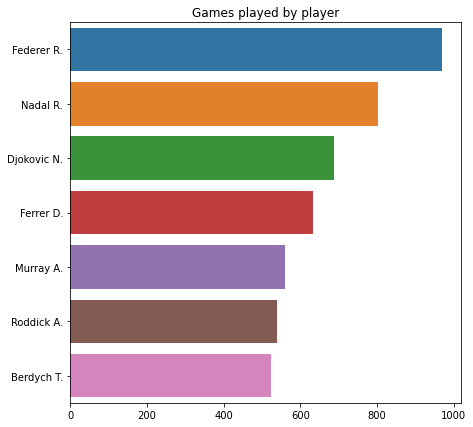

In [ ]:
plt.figure(figsize=(7,7))
sns.barplot(y=data.Winner.value_counts().head(7).index,
            x=data.Winner.value_counts().head(7).values);


plt.title('Games played by player');

Some players have been in much more games. Let's look at the top 20:

In [ ]:

TOP20 = Games['Played'][Games['Players'].head(20).index].sum()
TOP20_R = TOP20/Games['Played'].sum()
print("TOP20 players have played", "{0:.0%}".format(TOP20_R), "of the games")


TOP20 players have played 17% of the games


# **TESTS / WORK IN PROGRESS** 



## ARTHUR

In [ ]:
# Check odds offered by both bookmakers

x1=data.PSL.sum()
x2=data.B365L.sum()
x3=(x1-x2)/x2*100

print('Pinnacle odds on Losers are overall superior by',int(x3),'%')

y1=data.PSW.sum()
y2=data.B365W.sum()
y3=(y1-y2)/y2*100

print('Pinnacle odds on Winners are overall superior by',int(y3),'%')

Pinnacle odds on Losers are overall superior by 0 %
Pinnacle odds on Winners are overall superior by -11 %


In [ ]:
data_2=data
data_2["Pwinner365"]=1/data.B365W
data_2["Ploser365"]=1/data.B365L
data_2.tail()

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,Wsets,Lsets,Comment,PSW,PSL,B365W,B365L,elo_winner,elo_loser,proba_elo,year,WRank_cat,Pwinner365,Ploser365
44703,17,Dubai,Dubai Tennis Championships,2018-03-03,ATP500,Outdoor,Hard,The Final,3,Bautista Agut R.,Pouille L.,23,15,2.0,0.0,Completed,1.65,2.43,1.66,2.20,1835.901543,1842.459807,0.490563,2018,3,0.602410,0.454545
44704,16,Acapulco,Abierto Mexicano,2018-03-03,ATP500,Outdoor,Hard,Semifinals,3,Anderson K.,Donaldson J.,8,59,2.0,1.0,Completed,1.34,3.63,1.30,3.50,1843.576914,1647.967561,0.755103,2018,2,0.769231,0.285714
44705,18,Sao Paulo,Brasil Open,2018-03-03,ATP250,Indoor,Clay,Semifinals,3,Jarry N.,Zeballos H.,73,69,2.0,1.0,Completed,1.85,2.09,1.90,1.90,1588.293069,1619.758421,0.454841,2018,6,0.526316,0.526316
44706,16,Acapulco,Abierto Mexicano,2018-03-04,ATP500,Outdoor,Hard,The Final,3,Del Potro J.M.,Anderson K.,9,8,2.0,0.0,Completed,1.52,2.75,1.50,2.62,1966.532849,1851.413609,0.659862,2018,2,0.666667,0.381679
44707,18,Sao Paulo,Brasil Open,2018-03-04,ATP250,Indoor,Clay,The Final,3,Fognini F.,Jarry N.,20,73,2.0,1.0,Completed,1.38,3.38,1.36,3.25,1814.065865,1605.738153,0.768388,2018,3,0.735294,0.307692


In [ ]:
#Determination des probas réelle de B365
data_2["SumProb365"]=data_2["Pwinner365"]+data_2["Ploser365"]
data_2["Pwinner365_reel"]=data_2["Pwinner365"]/data_2.SumProb365
data_2["Ploser365_reel"]=data_2["Ploser365"]/data_2.SumProb365
data_2.head()

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,Wsets,Lsets,Comment,PSW,PSL,B365W,B365L,elo_winner,elo_loser,proba_elo,year,WRank_cat,Pwinner365,Ploser365,SumProb365,Pwinner365_reel,Ploser365_reel
0,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,Ljubicic I.,63,77,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5,2000,6,NaN,NaN,NaN,NaN,NaN
1,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Kiefer N.,Tarango J.,6,59,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5,2000,1 = Best ranked players,NaN,NaN,NaN,NaN,NaN
2,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Gaudio G.,Luxa P.,73,174,2.0,1.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5,2000,6,NaN,NaN,NaN,NaN,NaN
3,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,El Aynaoui Y.,Dupuis A.,33,78,2.0,1.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5,2000,4,NaN,NaN,NaN,NaN,NaN
4,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Cherkasov A.,Arazi H.,206,35,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5,2000,8 = Worst ranked players,NaN,NaN,NaN,NaN,NaN


<Figure size 1440x1440 with 0 Axes>

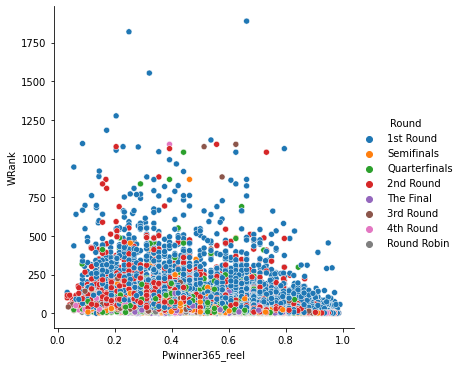

In [ ]:
#relation WRank Pwinner
plt.figure(figsize=(20,20))
sns.relplot(data=data_2, x="Pwinner365_reel", y="WRank", hue="Round")
plt.show()

<Figure size 1440x1440 with 0 Axes>

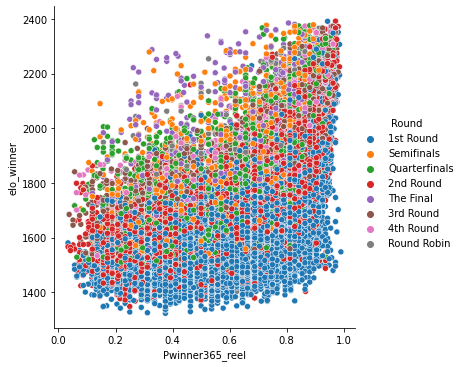

In [ ]:
#relation Pwinner elo winner
plt.figure(figsize=(20,20))
sns.relplot(data=data_2, x="Pwinner365_reel", y="elo_winner", hue="Round")

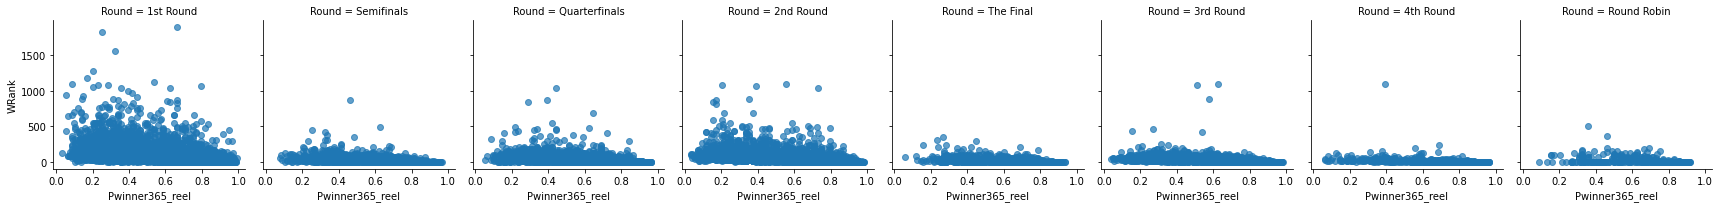

In [ ]:
#relation Pwinner Wrank discrétisation Round
g = sns.FacetGrid(data_2, col="Round")
g.map(plt.scatter, "Pwinner365_reel", "WRank", alpha=0.7)

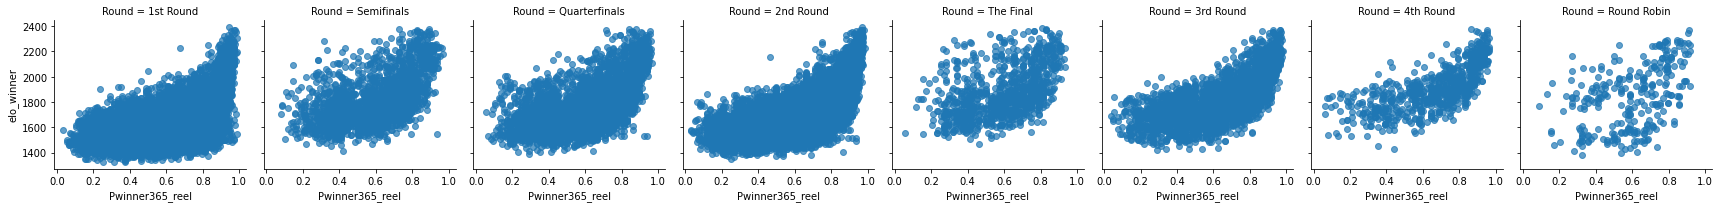

In [ ]:
#relation Pwinner elo winner discrétisation Round
g = sns.FacetGrid(data_2, col="Round")
g.map(plt.scatter, "Pwinner365_reel", "elo_winner", alpha=0.7)

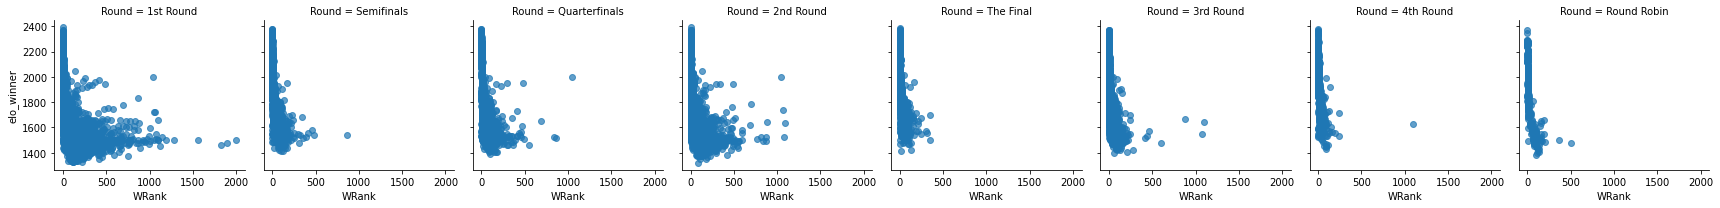

In [ ]:
#relation WRank elo winner discrétisation Round
g = sns.FacetGrid(data_2, col="Round")
g.map(plt.scatter, "WRank", "elo_winner", alpha=0.7)

In [ ]:
#g = sns.PairGrid(data_2)
#g.map(plt.scatter, alpha=0.6)
#g.add_legend()

### **Players cumul stats**

In [ ]:
# New dataframe preparation
#Enlever surface si non pertinent
df_ad = data.copy()
df_ad['w']=1
df_ad['l']=0
df_ad.head()

date=df_ad['Date']
round=df_ad['Round']
winner=df_ad['Winner']
loser=df_ad['Loser']
w=df_ad['w']
l=df_ad['l']
surface=df_ad['Surface']

df_ad_test = pd.concat([date,winner,loser,w,l,round,surface], axis = 1)
df_ad_test.head()


,Date,Winner,Loser,w,l,Round,Surface
0,2000-01-03,Dosedel S.,Ljubicic I.,1,0,1st Round,Hard
1,2000-01-03,Kiefer N.,Tarango J.,1,0,1st Round,Hard
2,2000-01-03,Gaudio G.,Luxa P.,1,0,1st Round,Hard
3,2000-01-03,El Aynaoui Y.,Dupuis A.,1,0,1st Round,Hard
4,2000-01-03,Cherkasov A.,Arazi H.,1,0,1st Round,Hard


In [ ]:
# Player Data creation

player=pd.concat([winner,loser], axis = 0)
statut=pd.concat([w,l], axis = 0)
date=pd.concat([date,date], axis = 0)
round=pd.concat([round,round], axis = 0)
surface=pd.concat([surface,surface], axis = 0)
df_ad_test = pd.concat([date,player, statut,round,surface], axis = 1)
df_ad_test.columns = ['Date', 'Player','Winner','Round','Surface']
df_ad_test.tail()

,Date,Player,Winner,Round,Surface
44703,2018-03-03,Pouille L.,0,The Final,Hard
44704,2018-03-03,Donaldson J.,0,Semifinals,Hard
44705,2018-03-03,Zeballos H.,0,Semifinals,Clay
44706,2018-03-04,Anderson K.,0,The Final,Hard
44707,2018-03-04,Jarry N.,0,The Final,Clay


In [ ]:
df_ad_test['Winner'].value_counts()

1    44708
0    44708
Name: Winner, dtype: int64

In [ ]:
# Pivot table gets stats by player
# (Considering 'date and Round' are enough to make each line unique without an index):

df_ad_fin = pd.pivot_table(df_ad_test,index=['Player','Date','Surface','Round'])
df_ad_fin

Winner
Player             Date       Surface Round            
 Hajek J.          2006-09-26 Clay    1st Round     1.0
                   2006-09-28 Clay    2nd Round     0.0
Abdulla M.         2005-01-04 Hard    1st Round     0.0
Abel M.            2002-09-09 Hard    1st Round     0.0
                   2002-09-30 Hard    1st Round     0.0
...                                                 ...
van Scheppingen D. 2005-06-13 Grass   1st Round     0.0
                   2005-07-19 Clay    1st Round     0.0
                   2007-02-21 Hard    1st Round     1.0
                   2007-02-22 Hard    2nd Round     0.0
van der Meer N.    2004-07-12 Clay    1st Round     0.0

[89342 rows x 1 columns]

In [ ]:
# Add cumul stats to the dataframe

df_ad_fin['Loser']=df_ad_fin['Winner'].apply(lambda x: 0.0 if x ==1 else 1.0)
df_ad_fin['cumulative_win']=df_ad_fin.groupby('Player')['Winner'].cumsum()
df_ad_fin['cumulative_lose']=df_ad_fin.groupby('Player')['Loser'].cumsum()
df_ad_fin['Win_rate']=df_ad_fin['cumulative_win']/(df_ad_fin['cumulative_win']+df_ad_fin['cumulative_lose'])*100
df_ad_fin.tail(10)

Winner  ...   Win_rate
Player             Date       Surface Round                  ...           
van Scheppingen D. 2004-10-01 Hard    Quarterfinals     0.0  ...  40.540541
                   2004-10-07 Hard    2nd Round         0.0  ...  39.473684
                   2004-10-11 Hard    1st Round         0.0  ...  38.461538
                   2005-01-03 Hard    1st Round         0.0  ...  37.500000
                   2005-02-02 Hard    1st Round         0.0  ...  36.585366
                   2005-06-13 Grass   1st Round         0.0  ...  35.714286
                   2005-07-19 Clay    1st Round         0.0  ...  34.883721
                   2007-02-21 Hard    1st Round         1.0  ...  36.363636
                   2007-02-22 Hard    2nd Round         0.0  ...  35.555556
van der Meer N.    2004-07-12 Clay    1st Round         0.0  ...   0.000000

[10 rows x 5 columns]

In [ ]:
# Add cumul stats to the dataframe

df_ad_fin['Loser']=df_ad_fin['Winner'].apply(lambda x: 0.0 if x ==1 else 1.0)
df_ad_fin['cumulative_win']=df_ad_fin.groupby(['Player','Surface'])['Winner'].cumsum()
df_ad_fin['cumulative_lose']=df_ad_fin.groupby(['Player','Surface'])['Loser'].cumsum()
df_ad_fin['Win_rate']=df_ad_fin['cumulative_win']/(df_ad_fin['cumulative_win']+df_ad_fin['cumulative_lose'])*100
df_ad_fin.tail(50)

Winner  ...    Win_rate
Player             Date       Surface Round                  ...            
van Lottum J.      2004-06-24 Grass   1st Round         0.0  ...   30.000000
                   2004-07-13 Clay    1st Round         0.0  ...   40.000000
                   2004-09-29 Hard    1st Round         0.0  ...   25.000000
                   2006-02-28 Hard    1st Round         0.0  ...   24.137931
van Scheppingen D. 2000-06-19 Grass   1st Round         0.0  ...    0.000000
                   2000-07-17 Clay    1st Round         1.0  ...  100.000000
                                      2nd Round         0.0  ...   50.000000
                   2001-12-31 Hard    1st Round         1.0  ...  100.000000
                                      2nd Round         0.0  ...   50.000000
                   2002-04-29 Clay    1st Round         0.0  ...   33.333333
                   2003-04-08 Clay    1st Round         0.0  ...   25.000000
                   2003-06-16 Grass   1st Round         1.0  ...   50.000000
                   2003-06-19 Grass   2nd Round         0.0  ...   33.333333
                   2003-07-07 Grass   1st Round         1.0  ...   50.000000
                   2003-07-10 Grass   2nd Round         0.0  ...   40.000000
                   2003-07-14 Clay    1st Round         1.0  ...   40.000000
                   2003-07-16 Clay    2nd Round         1.0  ...   50.000000
                   2003-07-18 Clay    Quarterfinals     0.0  ...   42.857143
                   2003-09-23 Hard    1st Round         0.0  ...   33.333333
                   2003-09-29 Hard    1st Round         1.0  ...   50.000000
                   2003-09-30 Hard    2nd Round         1.0  ...   60.000000
                   2003-10-02 Hard    3rd Round         0.0  ...   50.000000
                   2004-01-20 Hard    1st Round         0.0  ...   42.857143
                   2004-02-18 Hard    1st Round         0.0  ...   37.500000
                   2004-03-01 Hard    1st Round         1.0  ...   44.444444
                   2004-03-03 Hard    2nd Round         0.0  ...   40.000000
                   2004-04-13 Clay    1st Round         0.0  ...   37.500000
                   2004-05-17 Clay    1st Round         0.0  ...   33.333333
                   2004-05-24 Clay    1st Round         0.0  ...   30.000000
                   2004-06-14 Grass   1st Round         1.0  ...   50.000000
                   2004-06-17 Grass   2nd Round         0.0  ...   42.857143
                   2004-06-24 Grass   1st Round         0.0  ...   37.500000
                   2004-07-13 Clay    1st Round         1.0  ...   36.363636
                   2004-07-15 Clay    2nd Round         1.0  ...   41.666667
                   2004-07-16 Clay    Quarterfinals     1.0  ...   46.153846
                   2004-07-17 Clay    Semifinals        0.0  ...   42.857143
                   2004-09-01 Hard    1st Round         0.0  ...   36.363636
                   2004-09-14 Clay    1st Round         0.0  ...   40.000000
                   2004-09-28 Hard    1st Round         1.0  ...   41.666667
                   2004-09-30 Hard    2nd Round         1.0  ...   46.153846
                   2004-10-01 Hard    Quarterfinals     0.0  ...   42.857143
                   2004-10-07 Hard    2nd Round         0.0  ...   40.000000
                   2004-10-11 Hard    1st Round         0.0  ...   37.500000
                   2005-01-03 Hard    1st Round         0.0  ...   35.294118
                   2005-02-02 Hard    1st Round         0.0  ...   33.333333
                   2005-06-13 Grass   1st Round         0.0  ...   33.333333
                   2005-07-19 Clay    1st Round         0.0  ...   37.500000
                   2007-02-21 Hard    1st Round         1.0  ...   36.842105
                   2007-02-22 Hard    2nd Round         0.0  ...   35.000000
van der Meer N.    2004-07-12 Clay    1st Round         0.0  ...    0.000000

[50 rows x 5 columns]

In [ ]:

df_ad_fin.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 89342 entries, (' Hajek J.', '2006-09-26', 'Clay', '1st Round') to ('van der Meer N.', '2004-07-12', 'Clay', '1st Round')
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Winner           89342 non-null  float64
 1   Loser            89342 non-null  float64
 2   cumulative_win   89342 non-null  float64
 3   cumulative_lose  89342 non-null  float64
 4   Win_rate         89342 non-null  float64
dtypes: float64(5)
memory usage: 4.0+ MB


df_ad_test2=df_ad_test


In [ ]:
df_ad_test2=df_ad_test
df_ad_test2['Loser']=df_ad_test2['Winner'].apply(lambda x: 0.0 if x ==1 else 1.0)


In [ ]:
df_ad_fin2 = pd.pivot_table(df_ad_test2,index=['Player','Date','Round','Surface'], columns=['Surface'],fill_value=0)
df_ad_fin2

for i in df_ad_fin2.shape[0]:
  if df_ad_fin2["Surface"]=='Carpet':
    


Loser       ... Winner     
Surface                                         Carpet Clay  ...  Grass Hard
Player             Date       Round     Surface              ...            
 Hajek J.          2006-09-26 1st Round Clay         0  0.0  ...      0  0.0
                   2006-09-28 2nd Round Clay         0  1.0  ...      0  0.0
Abdulla M.         2005-01-04 1st Round Hard         0  0.0  ...      0  0.0
Abel M.            2002-09-09 1st Round Hard         0  0.0  ...      0  0.0
                   2002-09-30 1st Round Hard         0  0.0  ...      0  0.0
...                                                ...  ...  ...    ...  ...
van Scheppingen D. 2005-06-13 1st Round Grass        0  0.0  ...      0  0.0
                   2005-07-19 1st Round Clay         0  1.0  ...      0  0.0
                   2007-02-21 1st Round Hard         0  0.0  ...      0  1.0
                   2007-02-22 2nd Round Hard         0  0.0  ...      0  0.0
van der Meer N.    2004-07-12 1st Round Clay         0  1.0  ...      0  0.0

[89342 rows x 8 columns]

In [ ]:


df_ad_fin2['cumulative_win_Carpet']=df_ad_fin2.groupby(['Player','Surface'])['Winner'].cumsum()
df_ad_fin2['cumulative_lose_Carpet']=df_ad_fin2.groupby(['Player','Surface'])['Loser'].cumsum()
df_ad_fin2['Win_rate_Carpet']=df_ad_fin2['cumulative_win_Carpet']/(df_ad_fin2['cumulative_win_Carpet']+df_ad_fin2['cumulative_lose_Carpet'])*100
df_ad_fin2.tail(15)

KeyError: ignored

## GUILLAUME

In [ ]:
print('Players with less than 3 games:','\n\n',Games.loc[Games['Played']<3])

Players with less than 3 games: 

                 Players  Winner  Loser  Played  %Win
695        Nieminen J.      1.0    1.0     2.0   0.5
696   Dutra Da Silva R.     1.0    1.0     2.0   0.5
697            Cacic N.     1.0    1.0     2.0   0.5
699          Silva F.F.     1.0    1.0     2.0   0.5
702       Kosakowski D.     1.0    1.0     2.0   0.5
...                 ...     ...    ...     ...   ...
1397          Miketa D.     0.0    1.0     1.0   0.0
1398           Zhang Y.     0.0    1.0     1.0   0.0
1399           March O.     0.0    1.0     1.0   0.0
1400           Kutac R.     0.0    1.0     1.0   0.0
1401        Scherrer J.     0.0    1.0     1.0   0.0

[495 rows x 5 columns]


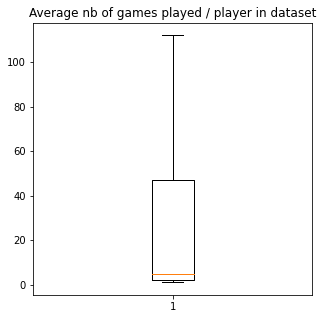

In [ ]:
plt.figure(figsize=(5,5))

plt.boxplot(Games.Played,showfliers=False);

plt.title('Average nb of games played / player in dataset');

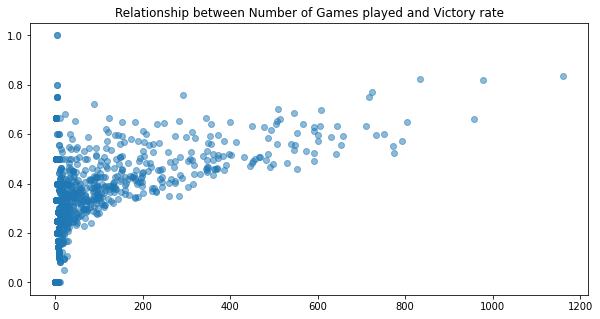

In [ ]:
# Number

plt.figure(figsize=(10,5))

plt.scatter(Games['Played'],Games['%Win'],alpha=0.5);
plt.title('Relationship between Number of Games played and Victory rate');

## WILL

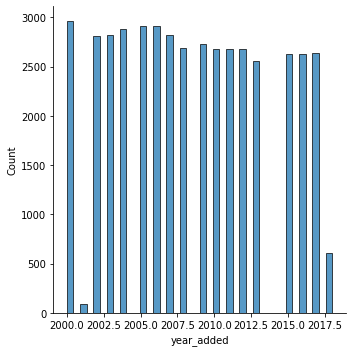

In [ ]:
data['year_added'] = (pd.to_datetime(data.Date)).dt.year
sns.displot(data.year_added);

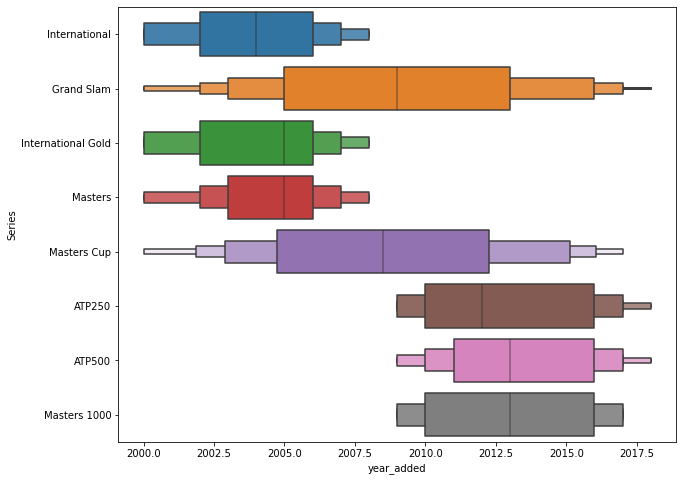

In [ ]:
plt.figure(figsize=(10, 8))
sns.boxenplot(x=data.year_added, y=data.Series);

In [ ]:
Winner_test = pd.DataFrame(data.groupby(['year_added', 'Winner']).size())
Loser_test = pd.DataFrame(data.groupby(['year_added', 'Loser']).size())

In [ ]:
Winner_test.reset_index(inplace=True)

In [ ]:
Winner_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3717 entries, 0 to 3716
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   year_added  3717 non-null   int64 
 1   Winner      3717 non-null   object
 2   0           3717 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 87.2+ KB


In [ ]:
Loser_test.reset_index(inplace=True)

In [ ]:
Loser_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5538 entries, 0 to 5537
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   year_added  5538 non-null   int64 
 1   Loser       5538 non-null   object
 2   0           5538 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 129.9+ KB


In [ ]:
#plt.figure(figsize=(10,20))
#sns.barplot(y=data.Loser.value_counts().head(60).index,
#           x=data.Loser.value_counts().head(60).values);

In [ ]:
#plt.figure(figsize=(10,20))
#sns.barplot(y=data.Winner.value_counts().head(60).index,
#            x=data.Winner.value_counts().head(60).values);

In [ ]:
Winner_test = Winner_test.rename(columns={'Winner':'Player', 0:'cumul_victoire'})
Loser_test = Loser_test.rename(columns={'Loser':'Player', 0:'cumul_defaite'})


In [ ]:
Result_test = Winner_test.merge(Loser_test, on = ['Player', 'year_added'], how= 'inner')
Result_test

,year_added,Player,cumul_victoire,cumul_defaite
0,2000,Agassi A.,36,15
1,2000,Agenor R.,6,16
2,2000,Alami K.,21,28
3,2000,Alonso J.,4,9
4,2000,Alvarez E.,6,7
...,...,...,...,...
3701,2018,Young D.,1,5
3702,2018,Youzhny M.,2,4
3703,2018,Zeballos H.,5,6
3704,2018,Zverev A.,6,3


In [ ]:
print(Result_test['year_added'].unique())

[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2015 2016 2017 2018]


Text(0.5, 1.0, "Boxplot du cumul des victoires et des défaites sur l'ensemble des données")

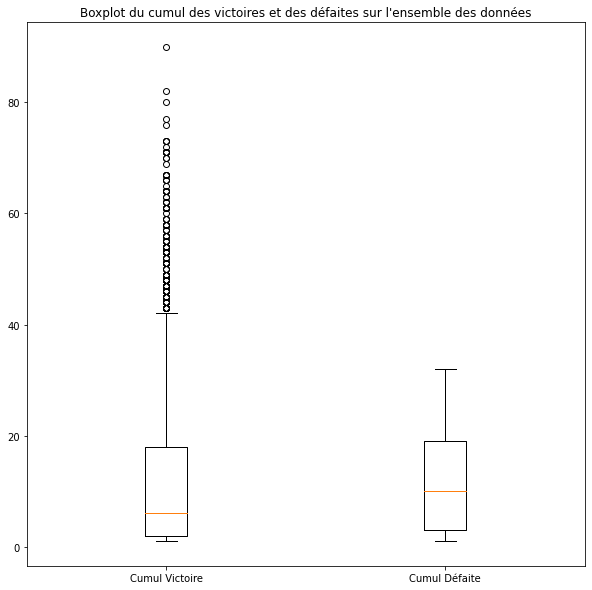

In [ ]:
plt.figure(figsize=(10,10))

plt.boxplot([Result_test.cumul_victoire,Result_test.cumul_defaite], labels=['Cumul Victoire', 'Cumul Défaite']);

plt.title("Boxplot du cumul des victoires et des défaites sur l'ensemble des données")


In [ ]:
Result_test["Player"] = Result_test["Player"].astype('category').cat.codes


In [ ]:
Result_test

,year_added,Player,cumul_victoire,cumul_defaite
0,2000,3,36,15
1,2000,4,6,16
2,2000,8,21,28
3,2000,13,4,9
4,2000,16,6,7
...,...,...,...,...
3701,2018,868,1,5
3702,2018,870,2,4
3703,2018,874,5,6
3704,2018,886,6,3


In [ ]:
Player_test = pd.DataFrame(Result_test.groupby(['Player','year_added']).size().sort_values(ascending=True))
Player_test.reset_index(inplace=True)
Player_test = Player_test.rename(columns={0:'Occurence'})
Player_test


,Player,year_added,Occurence
0,0,2006,1
1,566,2009,1
2,567,2007,1
3,567,2008,1
4,567,2009,1
...,...,...,...
3701,288,2017,1
3702,288,2018,1
3703,289,2013,1
3704,289,2016,1


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


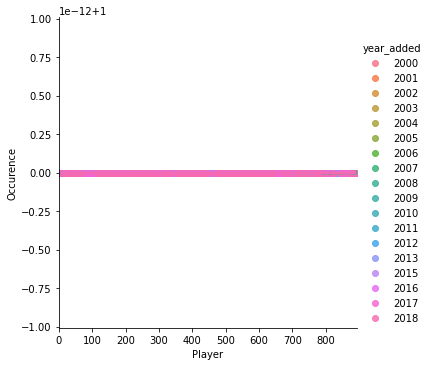

In [ ]:
#à retravailler
sns.lmplot(x='Player', y='Occurence', hue = 'year_added', lowess = True ,data=Player_test);